## TFM 2025  
### Autor : Andres Felipe Vargas Nuñez 
![](../Static_files/logo_ucm_ntic.png )

#### Este archivo entrena y guarda modelos.  

In [2]:
import os 
import uuid
import joblib
import random

from datetime import datetime

import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as mplt
import pandapower.networks as nw
import plotly.graph_objects as go

import pandapower.plotting as plt
import pandapower.timeseries as ts
from pandapower.control import ConstControl

from pandapower.timeseries.data_sources.frame_data import DFData

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional,Dense, Reshape, Conv2D,Conv3D,MaxPooling2D, UpSampling2D ,BatchNormalization,Dropout, Input, Masking , Flatten 



In [ ]:
def create_custom_network(num_buses, num_loads, connection_type="tree"):
    # Crear una red vacía
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {i+1}") for i in range(num_buses)]

    loads = [
        pp.create_load(net, bus=buses[random.randint(0, num_buses - 1)], 
                       p_mw=random.uniform(1.0, 5.0), 
                       q_mvar=random.uniform(0.5, 2.5), 
                       name=f"Load {i+1}") 
        for i in range(num_loads)
    ]
    std_types = pp.available_std_types(net, element='line')
    if connection_type == "tree":
        for i in range(1, num_buses):
            parent_bus = random.choice(buses[:i])
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net,name=f"line {i+1}" ,from_bus=parent_bus, to_bus=buses[i], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                
    elif connection_type == "mesh":
        for i in range(1, num_buses):
            for j in range(i):
                if random.random() < 0.5:  
                    configuracion_aleatoria = random.choice(list(std_types.index))
                    pp.create_line(net, from_bus=buses[i], to_bus=buses[j], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                    
    elif connection_type == "ring":
        for i in range(num_buses):
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net, from_bus=buses[i], to_bus=buses[(i+1) % num_buses], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

            if random.random() < 0.3:  
                distant_bus = random.choice(buses)
                if distant_bus != buses[i] and distant_bus != buses[(i+1) % num_buses]:
                    pp.create_line(net, from_bus=buses[i], to_bus=distant_bus, length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

    else:
        raise ValueError("Tipo de conexión no válido. Usa 'tree' o 'ring'.")

    slack_bus = 0
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)

    return net

def create_network(net_type=0):
    if net_type == 0:
        net =nw.simple_four_bus_system()
    elif net_type == 1:   
        net =nw.case24_ieee_rts()
    elif net_type == 2:
        net = nw.case30()
    else:
        net = nw.case14()
    return net

def calculate_resistance(distance_km):
    resistivity = 0.017 
    area = 1.0  
    resistance = (resistivity / area) * distance_km
    return resistance

def configure_output_writer(net, output_path):
    return ts.OutputWriter(net, output_path=output_path, output_file_type=".xlsx")

def create_profile_data(time_steps, net):
    profile_data = np.random.rand(time_steps, len(net.load))
    return ts.DFData(pd.DataFrame(profile_data))

def configure_constant_load_control(net, ds):
    return ConstControl(net, element='load', element_index=net.load.index, variable='scaling', data_source=ds, profile_name=net.load.index)

def log_variables(ow):
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_gen', 'p_mw')
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_load', 'q_mvar')

def run_simulation(net, time_steps) -> bool:
    try:
        ts.run_timeseries(net, time_steps)
        return True
    except Exception as e:
        print(f"Error durante la ejecución de series temporales: {e}")
        return False

def load_results(output_path):
    res_bus = pd.read_excel(f'{output_path}/res_bus/vm_pu.xlsx', header=None)
    res_load_p_mw = pd.read_excel(f'{output_path}/res_load/p_mw.xlsx', header=None)
    res_load_q_mvar = pd.read_excel(f'{output_path}/res_load/q_mvar.xlsx', header=None)
    res_line = pd.read_excel(f'{output_path}/res_line/loading_percent.xlsx')
    lines_config = pd.read_csv(f'{output_path}/line_configuration.csv', header=0)
    loads_config = pd.read_csv(f'{output_path}/loads_configuration.csv', header=0)
    return res_bus, res_load_p_mw, res_load_q_mvar, res_line , lines_config, loads_config

def format_load_data(res_load, load_bus_ids, value_name):
    res_load.columns = ['time_step'] + [f'{bus}' for bus in load_bus_ids]
    res_load = res_load[~res_load['time_step'].isna()]
    res_load = res_load.reset_index().melt(id_vars=['index'], var_name='node_id', value_name=value_name)
    res_load = res_load.query("node_id != 'time_step'")
    return res_load

def format_bus_data(res_bus, max_range):
    res_bus.columns = ['time_step', 'line_id'] + [f'{bus}' for bus in range(1, max_range)]
    res_bus = res_bus[~res_bus['time_step'].isna()]
    res_bus = res_bus.reset_index().melt(id_vars=['index'], var_name='node_id', value_name='vm_pu')
    res_bus = res_bus.query("node_id != 'time_step' & node_id != 'line_id'")
    return res_bus

def merge_data(res_bus, res_load_p_mw, res_load_q_mvar):
    res_load_p_mw.set_index(['index', 'node_id'], inplace=True)
    res_bus.set_index(['index', 'node_id'], inplace=True)
    res_load_q_mvar.set_index(['index', 'node_id'], inplace=True)
    df_combined = res_bus.join(res_load_p_mw, on=['index', 'node_id'] ,lsuffix='__bus', rsuffix='_loadp') 
    df_combined = df_combined.join(res_load_q_mvar, on=['index', 'node_id'], how="left",rsuffix='_loadq')
    return df_combined

def create_incidence_matrix(net):
    incidence_matrix = pp.topology.create_nxgraph(net)
    return pd.DataFrame(nw.to_pandas_adjacency(incidence_matrix, nodelist=net.bus.index, weight='weight'))

def create_line_data(net):
    line_data = []
    for line in net.line.index:
        from_bus = net.line.from_bus.at[line]
        to_bus = net.line.to_bus.at[line]
        length_km = net.line.length_km.at[line]
        r_ohm_per_km = net.line.r_ohm_per_km.at[line]
        line_data.append({'line_id': line, 'from_bus': from_bus, 'to_bus': to_bus, 'length_km': length_km, 'r_ohm_per_km': r_ohm_per_km})
    return pd.DataFrame(line_data)

def print_inciden_matrix(df):
    df = df.applymap(lambda x: 0 if x == '0' or x == 0 else 1)

def incidence_matrix(line_df):
    from_buses = line_df['from_bus']
    to_buses = line_df['to_bus']
    length_kms = line_df['length_km']
    r_ohm_per_kms = line_df['r_ohm_per_km']
    num_buses = max(from_buses.max(), to_buses.max()) + 1
    num_lines = len(line_df)
    incidence_matrix = np.zeros((num_buses, num_lines), dtype=tuple)
    # (length_km,r_ohm_per_km
    for i, (from_bus, to_bus,length_km,r_ohm_per_km) in enumerate(zip(from_buses, to_buses,length_kms,r_ohm_per_kms)):
        incidence_matrix[from_bus, i] = 1
        incidence_matrix[to_bus, i] = 1

    df = pd.DataFrame(incidence_matrix, columns=[i for i in range(num_lines)], index=[j for j in range(num_buses)])

    return df

def plot_simple_df_net(df, is_print_lines=False):
    # df = df.transpose()
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {bus}") for bus in range(len(df.index))]
    number_line = 0

    for col in df.columns:
        from_bus = None
        to_bus = None
        for i, value in df[col].items():
                if value == 1 and from_bus is None:
                        from_bus = int(i)
                if value == 0.68 and to_bus is None:
                        to_bus = int(i)
        
        if  (not from_bus is None and 
        not to_bus is None ): 
                length_km = 10
                pp.create_line(net, name=f"number_line{number_line}", from_bus=from_bus, to_bus=to_bus, length_km=length_km, std_type="NAYY 4x50 SE")
                number_line += 1

    slack_bus = 0 
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    other_gen_buses = random.sample([b for b in buses if b != slack_bus], k=max(1,  len(df.index) // 4))
    for bus in other_gen_buses:
        pp.create_gen(net, bus=bus, p_mw=random.uniform(3.0, 6.0), vm_pu=1.02, name=f"Gen {bus}")

    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)
    fig = plt.simple_plot(net)
    if is_print_lines:
        print(net.line)

    if is_print_lines:
        print(net.line)

def comparar_matrices(matrix1, matrix2):
    df_resta = matrix1 - matrix2
    suma_total = df_resta.values.sum()
    return suma_total

def ajustar_celdas(df,y=0.4):
    df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
    for col in df.columns:
        top_values = df[col].nlargest(2)
        if len(top_values) > 0:
            top_indices = top_values.index
            if top_values.sum() < y :
                continue
            if len(top_indices) > 0:
                df_nuevo.loc[top_indices[0], col] = 1
            if len(top_indices) > 1:
                df_nuevo.loc[top_indices[1], col] = 0.68
    return df_nuevo

def print_bw_matrix(df):
    mplt.matshow(df, cmap='gray')
    mplt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns)
    mplt.yticks(ticks=np.arange(df.shape[0]), labels=df.index)
    mplt.colorbar()
    mplt.show()

def print_int_matrix(df,text="Generate Model Data"):
    print("*" *30 + text + "*"*30)
    print( "*"*60 + "*" *len(text) )
    print(df)

def plot_and_print_result(df,text:str="Generate Model Data" , type_output:int = 0):
    if type_output == 1 :
        print_int_matrix(df,text)
    elif type_output ==  2:
        print_bw_matrix(df)
    elif type_output ==  3:
        plot_simple_df_net(df)
    return True

In [4]:
max_size_nodes = 24
nodes = 18
lines = nodes-1
loads = 9
num_intervals = 48
base_output_path = f"../Data-3"
folder_name = "AV1-test"
y_size=max_size_nodes-1
x_size=max_size_nodes


In [5]:

common_folder=f"{base_output_path}/train_data/{folder_name}/"
train_files = [os.path.join(common_folder, nombre) for nombre in os.listdir(common_folder)]
df_total=pd.DataFrame()

def pad_dataframe(df, max_size):
    padded_array = np.zeros(((max_size), max_size-1))
    rows, cols = df.shape
    padded_array[:rows, :cols] = df.values

    return pd.DataFrame(padded_array)

def add_columns(df, prefix, total_columns):
   columns = [col.split("_")[-1] for col in df.columns if prefix in col ] 
   max_col = max(columns)
   print(max_col)
   for col in range( int(max_col) , total_columns+1):
       column = f" {prefix}{col}"
       df[column]= 0.0
       
       
   return df

def parse_tuple(x):
    if x == '0':
        return 0
    else:
        return 1

for folder in (train_files):
    load_csv_file = f'{folder}/load/load.csv' 
    df = pd.read_csv(load_csv_file,index_col=[0] ,header=[0])
    incidence_matrix_file = f'{folder}/indicen_matriz/incidence_matrix.csv'
    df_incidence_matrix = pd.read_csv(incidence_matrix_file,index_col=[0])
    df_incidence_matrix = df_incidence_matrix.replace(3, 0.68)
    df_incidence_matrix = df_incidence_matrix.replace(5, 1)
    df_incidence_matrix = df_incidence_matrix.transpose()
    parsed_df = pad_dataframe(df_incidence_matrix, max_size_nodes)
    t  = np.array(parsed_df).flatten()
    df["Y"] =  [t] * len(df) 
    df_total=pd.concat([df_total,df])


df_total = add_columns(df_total, 'va_degree_', max_size_nodes)
df_total = add_columns(df_total, 'res_p_', max_size_nodes)
df_total = add_columns(df_total, 'res_q_', max_size_nodes)
df_total = add_columns(df_total, 'vm_pu_', max_size_nodes)
df_total = df_total.fillna(0)
columnas_excluir = ['nodes_numbers', 'loads_number', 'Y']
df_total[columnas_excluir] = df_total[columnas_excluir]
df_restantes = df_total.drop(columns=columnas_excluir).astype(float)
df_total = pd.concat([df_total[columnas_excluir], df_restantes], axis=1)

df_total = df_total.sort_index(axis=1)
print(df_total.shape)

9


C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\3518115292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column]= 0.0


9


C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\3518115292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column]= 0.0


9


C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\3518115292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column]= 0.0


9


C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\3518115292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column]= 0.0


(1048320, 129)


In [6]:
print(df_total.shape)

(1048320, 129)


In [7]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler , RobustScaler ,StandardScaler
from sklearn.model_selection import train_test_split

columns_out= ['Y']
scaler = MinMaxScaler()
X = df_total.drop(columns_out,axis=1).values
X =  scaler.fit_transform(X)
Y = df_total[columns_out].values
num_samples = len(X) // num_intervals
X = X.reshape((num_samples,num_intervals,len(df_total.drop(columns_out,axis=1).columns)))
Y = (df_total['Y'].values)
Y = np.stack(Y)
Y = Y.reshape((num_samples, num_intervals,max_size_nodes, max_size_nodes-1 ))
print(X.shape, Y.shape)

# Dividir los datos en entrenamiento + validación y prueba
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.1, random_state=45)

# Dividir los datos temporales en entrenamiento y validación
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(21840, 48, 128) (21840, 48, 24, 23)
(14742, 48, 128) (14742, 48, 24, 23)
(4914, 48, 128) (4914, 48, 24, 23)
(2184, 48, 128) (2184, 48, 24, 23)


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D

# Definir los parámetros
nodes = max_size_nodes
lines = max_size_nodes - 1

# Crear el modelo
model_lstm_cnn = Sequential()
model_lstm_cnn.add(LSTM(96, input_shape=(X.shape[1], X.shape[2])))
model_lstm_cnn.add(Dense(num_intervals * nodes * lines))
model_lstm_cnn.add(Reshape((num_intervals, nodes, lines)))
model_lstm_cnn.add(Conv2D(lines, (3, 3), activation='relu', padding='same'))
model_lstm_cnn.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn.add(UpSampling2D((2, 2)))
model_lstm_cnn.add(Dense(nodes * lines))
model_lstm_cnn.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn.add(Conv2D(lines, (3, 3), activation='sigmoid', padding='same'))

# Compilar el modelo con MSE como función de pérdida
model_lstm_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar el resumen del modelo
model_lstm_cnn.summary()


c:\Users\afgvn\Documents\backup\UCM-2024\repos\TFM\UCM-ENRS\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26496)          │     2,570,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 24, 23)     │         4,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48, 24, 552)    │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 24, 23)     │         4,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,798,791 (10.68 MB)

 Trainable params: 2,798,791 (10.68 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.regularizers import l2

# Definir los parámetros
nodes = max_size_nodes
lines = max_size_nodes - 1

# Crear el modelo
model_lstm_cnn2 = Sequential()
model_lstm_cnn2.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn2.add(LSTM(128, kernel_regularizer=l2(0.01)))
model_lstm_cnn2.add(Dense(num_intervals * nodes * lines))
model_lstm_cnn2.add(Reshape((num_intervals, nodes, lines)))
model_lstm_cnn2.add(Conv2D(lines, (3, 3), activation='relu', padding='same'))
model_lstm_cnn2.add(BatchNormalization())
model_lstm_cnn2.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn2.add(Dropout(0.25))
model_lstm_cnn2.add(UpSampling2D((2, 2)))
model_lstm_cnn2.add(Dense(nodes * lines))
model_lstm_cnn2.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn2.add(Conv2D(lines, (3, 3), activation='linear', padding='same'))

model_lstm_cnn2.compile(optimizer='adam', loss='mean_squared_error')

model_lstm_cnn2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 48, 24, 23)     │         4,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 24, 23)     │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 48, 24, 552)    │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 24, 23)     │         4,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,691,939 (14.08 MB)

 Trainable params: 3,691,893 (14.08 MB)

 Non-trainable params: 46 (184.00 B)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Reshape, Conv2D, BatchNormalization, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.regularizers import l2


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D

# Definir los parámetros
nodes = max_size_nodes
lines = max_size_nodes - 1

model_lstm_cnn3 = Sequential()
model_lstm_cnn3.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn3.add(LSTM(96 ,return_sequences=True ))
model_lstm_cnn3.add(Dropout(0.2))  # Añadir Dropout
model_lstm_cnn3.add(LSTM(48))
model_lstm_cnn3.add(Dense(num_intervals * nodes * lines))
model_lstm_cnn3.add(Dropout(0.25))
model_lstm_cnn3.add(Reshape((num_intervals, nodes, lines)))
model_lstm_cnn3.add(Conv2D(lines, (2, 2), activation='relu', padding='same'))
model_lstm_cnn3.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn3.add(Conv2D(nodes*lines, (5, 5), activation='relu', padding='same'))
model_lstm_cnn3.add(BatchNormalization())
model_lstm_cnn3.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn3.add(Dense(nodes * lines))
model_lstm_cnn3.add(Dropout(0.25))
model_lstm_cnn3.add(UpSampling2D((2, 2)))
model_lstm_cnn3.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn3.add(Conv2D(lines, (2, 2), activation='sigmoid', padding='same'))

model_lstm_cnn3.compile(optimizer='adam', loss='mean_squared_error')
model_lstm_cnn3.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 48)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26496)          │     1,298,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 24, 23)     │         2,139 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 24, 24)     │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 48, 24, 552)    │       331,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 24, 552)    │         2,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 12, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24, 12, 552)    │       305,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 12, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 48, 24, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 24, 23)     │         2,231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,180,378 (8.32 MB)

 Trainable params: 2,179,274 (8.31 MB)

 Non-trainable params: 1,104 (4.31 KB)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Reshape, Conv2D, BatchNormalization, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.regularizers import l2


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D

# Definir los parámetros
nodes = max_size_nodes
lines = max_size_nodes - 1

model_lstm_cnn4 = Sequential()
model_lstm_cnn4.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn4.add(LSTM(96 ,return_sequences=True ))
model_lstm_cnn4.add(Dropout(0.2))  # Añadir Dropout
model_lstm_cnn4.add(LSTM(48))
model_lstm_cnn4.add(Dense(num_intervals * nodes * lines))
model_lstm_cnn4.add(Dropout(0.25))
model_lstm_cnn4.add(Reshape((num_intervals, nodes, lines)))
model_lstm_cnn4.add(Conv2D(lines, (2, 2), activation='sigmoid', padding='same'))
model_lstm_cnn4.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn4.add(Conv2D(nodes*lines, (5, 5), activation='relu', padding='same'))
model_lstm_cnn4.add(BatchNormalization())
model_lstm_cnn4.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn4.add(Dense(nodes * lines))
model_lstm_cnn4.add(Dropout(0.25))
model_lstm_cnn4.add(UpSampling2D((2, 2)))
model_lstm_cnn4.add(Conv2D(nodes*lines, (5, 5), activation='relu', padding='same'))
model_lstm_cnn4.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn4.add(Conv2D(lines, (2, 2), activation='sigmoid', padding='same'))

model_lstm_cnn4.compile(optimizer='adam', loss='mean_squared_error')
model_lstm_cnn4.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 48, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 48)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 26496)          │     1,298,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 26496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 24, 23)     │         2,139 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 24, 24)     │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 24, 552)    │       331,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 24, 552)    │         2,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 12, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24, 12, 552)    │       305,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 12, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 48, 24, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 48, 24, 552)    │     7,618,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 24, 23)     │         2,231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,798,530 (37.38 MB)

 Trainable params: 9,797,426 (37.37 MB)

 Non-trainable params: 1,104 (4.31 KB)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# model_lstm_cnn.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])
# model_lstm_cnn2.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])
# model_lstm_cnn3.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])
model_lstm_cnn2.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])


Epoch 1/20
922/922 ━━━━━━━━━━━━━━━━━━━━ 40:50 3s/step - loss: 2.119 ━━━━━━━━━━━━━━━━━━━━ 1:07 73ms/step - loss: 2.09 ━━━━━━━━━━━━━━━━━━━━ 1:05 71ms/step - loss: 2.07 ━━━━━━━━━━━━━━━━━━━━ 1:04 71ms/step - loss: 2.06 ━━━━━━━━━━━━━━━━━━━━ 1:05 71ms/step - loss: 2.04 ━━━━━━━━━━━━━━━━━━━━ 1:05 71ms/step - loss: 2.02 ━━━━━━━━━━━━━━━━━━━━ 1:05 72ms/step - loss: 2.01 ━━━━━━━━━━━━━━━━━━━━ 1:05 72ms/step - loss: 1.99 ━━━━━━━━━━━━━━━━━━━━ 1:05 71ms/step - loss: 1.97 ━━━━━━━━━━━━━━━━━━━━ 1:05 72ms/step - loss: 1.96 ━━━━━━━━━━━━━━━━━━━━ 1:05 72ms/step - loss: 1.94 ━━━━━━━━━━━━━━━━━━━━ 1:05 72ms/step - loss: 1.93 ━━━━━━━━━━━━━━━━━━━━ 1:05 72ms/step - loss: 1.92 ━━━━━━━━━━━━━━━━━━━━ 1:05 73ms/step - loss: 1.90 ━━━━━━━━━━━━━━━━━━━━ 1:05 73ms/step - loss: 1.89 ━━━━━━━━━━━━━━━━━━━━ 1:05 73ms/step - loss: 1.87 ━━━━━━━━━━━━━━━━━━━━ 1:05 73ms/step - loss: 1.86 ━━━━━━━━━━━━━━━━━━━━ 1:05 73ms/step - loss: 1.85 ━━━━━━━━━━━━━━━━━━━━ 1:05 73ms/step - loss: 1.83 ━━━━━━━━━━━━━━━━━━━━ 1:05 72ms/step - loss: 1.82 ━

In [18]:
import joblib
model_output_path ="../Modelos/{}"
model_lstm_cnn = joblib.load(model_output_path.format("model_lstm_cnn_V3_final"))


*************** Validacion modelos ******************
************ Casos de pruebas  728 *******
 modelo evaluado model_lstm_cnn_V5
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/ste ━━━

C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.6

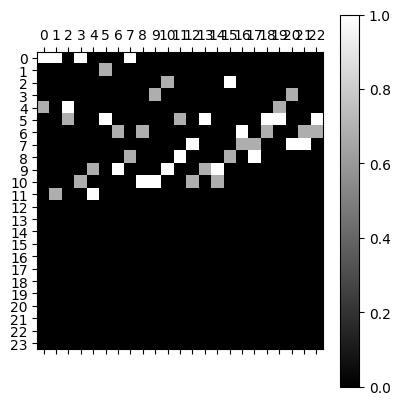

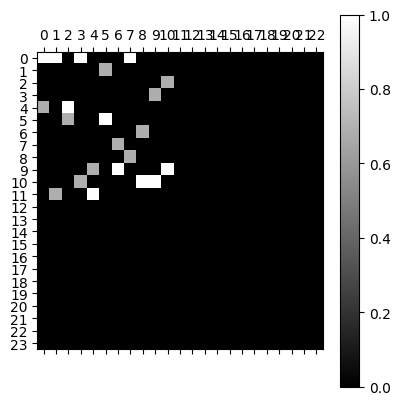

69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/ste ━━━

C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.6

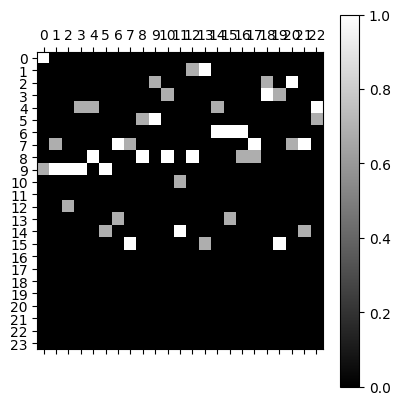

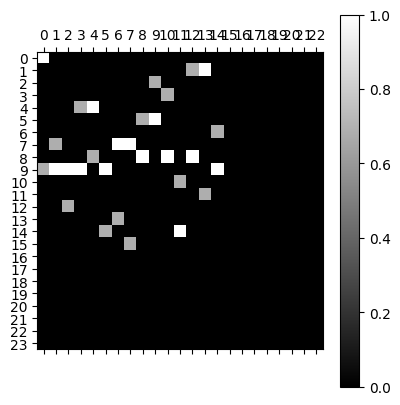

69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/ste ━━━

C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.6

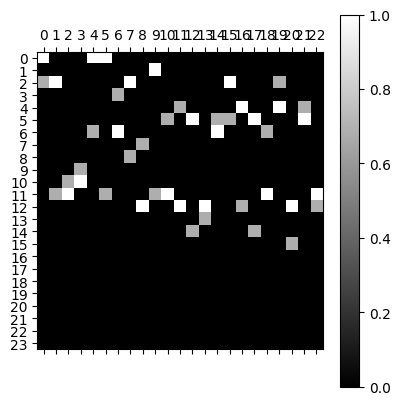

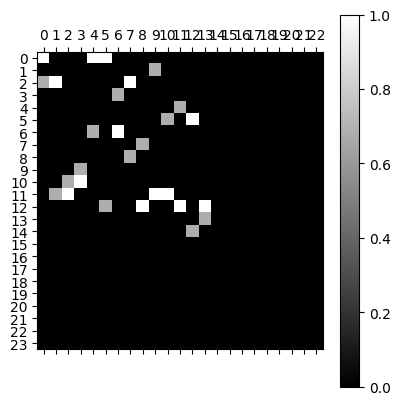

69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/ste ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/ste ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/ste ━━━

C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.6

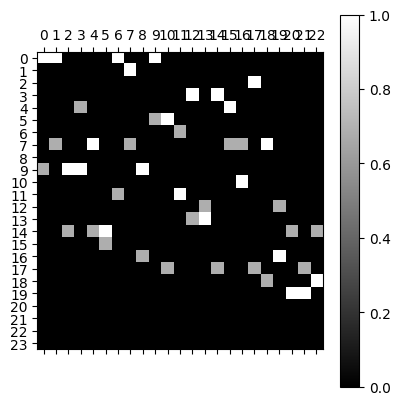

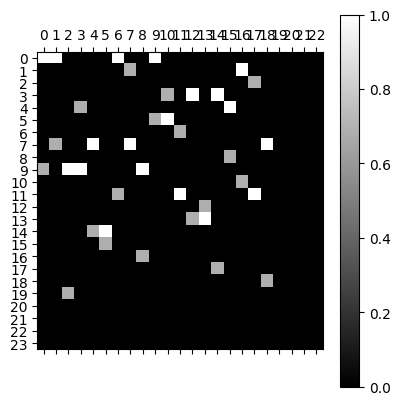

69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/ste ━━━

C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.68
C:\Users\afgvn\AppData\Local\Temp\ipykernel_28196\2557068110.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.68' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[top_indices[1], col] = 0.6

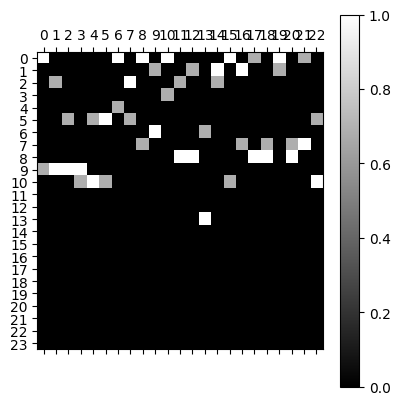

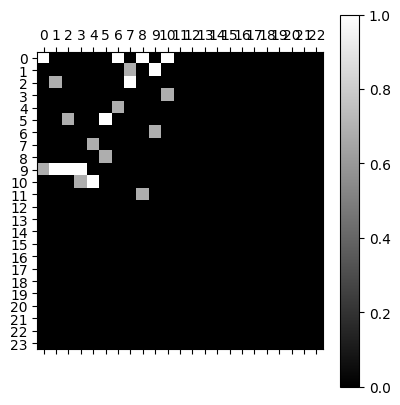

 Resultados 
[0.033466666666666665, 0.026446376811594202, 0.025889855072463767, 0.02166376811594203, 0.038863768115942034]
[]
[22.966533333333334, 22.973553623188405, 22.974110144927536, 22.978336231884057, 22.96113623188406]
114.85366956521739
115
0.0


In [30]:
results =[]
interval=2
from scipy.ndimage import convolve

models = {
        "model_lstm_cnn_V1":model_lstm_cnn,
        "model_lstm_cnn_V5":model_lstm_cnn2,
        "model_lstm_cnn_V3":model_lstm_cnn3,
        "model_lstm_cnn_V4":model_lstm_cnn4,
        }


models = {
        "model_lstm_cnn_V5":model_lstm_cnn,
        }

type_output = 2
number_eval = int(len(X_test)/3)

print("*************** Validacion modelos ******************")
print(f"************ Casos de pruebas  {number_eval} *******")
number_eval = 5
for model_name , model_val in models.items() :
    print(f" modelo evaluado {model_name}")
    results = []
    for index in range(number_eval) : 
        predicted_image = model_val.predict(X_test)
        test_image = predicted_image[index][interval]

        data_out = []
        for i in range(test_image.shape[0]):
            row = []
            for j in range(test_image.shape[1]):
                val = test_image[i, j]
                row.append(val)
            data_out.append(row)
        
        df_topo_out = pd.DataFrame(data_out, columns=[f'{i}' for i in range(test_image.shape[1])])

        pd.DataFrame(df_topo_out)

        print(df_topo_out)
        df_topo_out = ajustar_celdas(df_topo_out,y=0.6)
        plot_and_print_result(df_topo_out ,"Test Evaluate Data",type_output=type_output)

        test_image_val = Y_test[index][interval]
        data_val = []
        for i in range(test_image_val.shape[0]):
            row = []
            for j in range(test_image_val.shape[1]):
                row.append(test_image_val[i, j])
            data_val.append(row)

        df_topo_val = pd.DataFrame(data_val, columns=[f'{i}' for i in range(test_image_val.shape[1])])

        plot_and_print_result(df_topo_val ,"Test Model Data",type_output=type_output)
        mse = np.mean((df_topo_out - df_topo_val)**2)
        results.append(mse)

    val_reuslt = ([True for result in results if result == lines])
    val_reuslt_sum = ([lines-result for result in results ])
    print("="*30)
    print(" Resultados ")
    print((results))
    print((val_reuslt))
    print((val_reuslt_sum))
    print(sum(val_reuslt_sum))
    print(len(results)*lines)
    print(len(val_reuslt)/len(results))
    print("="*30)

In [39]:
import joblib
model_output_path ="../Modelos/{}"

if not os.path.exists(model_output_path.format("")):
    os.makedirs(model_output_path.format(""))

for model_name , model in models.items():
    file_moldel = model_output_path.format(model_name)
    joblib.dump(model,file_moldel)